In [1]:
import numpy as np
import pandas as pd
import os 

import matplotlib.pyplot as plt
import matplotlib.font_manager
plt.style.use('seaborn-darkgrid')

from time import process_time

from sklearn.preprocessing import MinMaxScaler

In [2]:
# Import all models
from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
# from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from pyod.models.loci import LOCI
from pyod.models.mcd import MCD
from pyod.models.ocsvm import OCSVM
from pyod.models.pca import PCA
from pyod.models.sos import SOS
from pyod.models.lscp import LSCP
from pyod.models.cof import COF
from pyod.models.sod import SOD

In [3]:
df1 = pd.read_csv("time_data_a1.csv",encoding="utf-8",index_col=0)
df2 = pd.read_csv("time_data_a2.csv",encoding="utf-8",index_col=0)
df3 = pd.read_csv("time_data_a3.csv",encoding="utf-8",index_col=0)
df4 = pd.read_csv("time_data_a4.csv",encoding="utf-8",index_col=0)
df5 = pd.read_csv("time_data_a5.csv",encoding="utf-8",index_col=0)
df6 = pd.read_csv("time_data_b1.csv",encoding="utf-8",index_col=0)
df7 = pd.read_csv("time_data_b2.csv",encoding="utf-8",index_col=0)
df8 = pd.read_csv("time_data_b3.csv",encoding="utf-8",index_col=0)
df9 = pd.read_csv("time_data_b4.csv",encoding="utf-8",index_col=0)
df10 = pd.read_csv("time_data_b5.csv",encoding="utf-8",index_col=0)

In [4]:
data_a  = pd.concat([df1,df2,df3,df4,df5])
data_a.reset_index(inplace=True,drop=True)

data_b  = pd.concat([df6,df7,df8,df9,df10])
data_b.reset_index(inplace=True,drop=True)

In [1]:
# Define the number of inliers and outliers
n_samples = 150
outliers_fraction = 0.2
clusters_separation = [0]

In [6]:
# initialize a set of detectors for LSCP
detector_list = [LOF(n_neighbors=5), LOF(n_neighbors=10), LOF(n_neighbors=15),
                 LOF(n_neighbors=20), LOF(n_neighbors=25), LOF(n_neighbors=30),
                 LOF(n_neighbors=35), LOF(n_neighbors=40), LOF(n_neighbors=45),
                 LOF(n_neighbors=50)]

In [17]:
random_state = 666
# Define nine outlier detection tools to be compared
classifiers = {
    'Angle-based Outlier Detector (ABOD)':
        ABOD(contamination=outliers_fraction),
    'Cluster-based Local Outlier Factor (CBLOF)':
        CBLOF(contamination=outliers_fraction,
              check_estimator=False, random_state=random_state),
    #'Feature Bagging':
    #   FeatureBagging(LOF(n_neighbors=35),
    #                 contamination=outliers_fraction,
    #                   random_state=random_state),
    'Histogram-base Outlier Detection (HBOS)': HBOS(
        contamination=outliers_fraction),
    'Isolation Forest': IForest(contamination=outliers_fraction,
                                random_state=random_state),
    'K Nearest Neighbors (KNN)': KNN(
        contamination=outliers_fraction),
    'Average KNN': KNN(method='mean',
                       contamination=outliers_fraction),
    # 'Median KNN': KNN(method='median',
    #                   contamination=outliers_fraction),
    'Local Outlier Factor (LOF)':
        LOF(n_neighbors=35, contamination=outliers_fraction),
    # 'Local Correlation Integral (LOCI)':
    #     LOCI(contamination=outliers_fraction),
    'Minimum Covariance Determinant (MCD)': MCD(
        contamination=outliers_fraction, random_state=random_state),
    'One-class SVM (OCSVM)': OCSVM(contamination=outliers_fraction),
    'Principal Component Analysis (PCA)': PCA(
        contamination=outliers_fraction, random_state=random_state),
    # 'Stochastic Outlier Selection (SOS)': SOS(
    #     contamination=outliers_fraction),
    'Locally Selective Combination (LSCP)': LSCP(
        detector_list, contamination=outliers_fraction,
        random_state=random_state),
    # 'Connectivity-Based Outlier Factor (COF)':
    #     COF(n_neighbors=35, contamination=outliers_fraction),
    # 'Subspace Outlier Detection (SOD)':
    #     SOD(contamination=outliers_fraction),
}


In [18]:
for i, clf in enumerate(classifiers.keys()):
    print('Model', i + 1, clf)

Model 1 Angle-based Outlier Detector (ABOD)
Model 2 Cluster-based Local Outlier Factor (CBLOF)
Model 3 Histogram-base Outlier Detection (HBOS)
Model 4 Isolation Forest
Model 5 Local Outlier Factor (LOF)
Model 6 Minimum Covariance Determinant (MCD)
Model 7 One-class SVM (OCSVM)
Model 8 Principal Component Analysis (PCA)
Model 9 Locally Selective Combination (LSCP)


In [19]:
def outliers_detection(data):
    two_data = pd.concat([data,data],axis=1)
    two_data.columns=["Time_difference1","Time_difference2"]

    minmax = MinMaxScaler(feature_range=(0, 1))
    two_data[['Time_difference1','Time_difference2']] = minmax.fit_transform(two_data[two_data.columns])
    
    X1= two_data['Time_difference1'].values.reshape(-1,1)
    X2 = two_data['Time_difference2'].values.reshape(-1,1)
    X = np.concatenate((X1,X2),axis=1)

    xx , yy = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
    plt.figure(figsize=(20, 15))
    for i, (clf_name, clf) in enumerate(classifiers.items()):
       
        clf.fit(X)
        
        scores_pred = clf.decision_function(X) * -1
      
        y_pred = clf.predict(X)
        n_inliers = len(y_pred) - np.count_nonzero(y_pred)
        n_outliers = np.count_nonzero(y_pred == 1)
    
        df1 = two_data
        df1['outlier'] = y_pred.tolist()
        inliers_people = np.array(df1['Time_difference1'][df1['outlier'] == 0]).reshape(-1,1)
        inliers_order = np.array(df1['Time_difference2'][df1['outlier'] == 0]).reshape(-1,1)
    
        
        outliers_people = df1['Time_difference1'][df1['outlier'] == 1].values.reshape(-1,1)
        outliers_order = df1['Time_difference2'][df1['outlier'] == 1].values.reshape(-1,1)
            
     
        threshold = np.percentile(scores_pred, 100 * outliers_fraction)
    
      
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
        Z = Z.reshape(xx.shape)
        
        plt.subplot(3,4,i+1)
        plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),cmap=plt.cm.Blues_r)
        a = plt.contour(xx, yy, Z, levels=[threshold],linewidths=2, colors='red')
        
       
        plt.contourf(xx, yy, Z, levels=[threshold, Z.max()],colors='orange')
        b = plt.scatter(x=inliers_people, y=inliers_order, c='white',s=20, edgecolor='k')    
        c = plt.scatter(x=outliers_people, y=outliers_order, c='black',s=20, edgecolor='k')
        
        plt.axis('tight')   
        plt.legend([a.collections[0], b,c], ['decision_functio', 'inliers','outliers'],
                    prop=matplotlib.font_manager.FontProperties(size=12),loc='upper right')
    
        plt.xlim((0, 1))
        plt.ylim((0, 1))
        ss = 'outliers: '+str(n_outliers)+' inliers: '+str(n_inliers)
        plt.title(clf_name)
        plt.xlabel(ss)
    plt.show();




C:\Users\s0970\anaconda3\envs\tensorflow\lib\site-packages\numpy\core\fromnumeric.py:3583: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\s0970\anaconda3\envs\tensorflow\lib\site-packages\numpy\core\_methods.py:185: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
C:\Users\s0970\anaconda3\envs\tensorflow\lib\site-packages\numpy\core\_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\s0970\anaconda3\envs\tensorflow\lib\site-packages\pyod\models\base.py:429: RuntimeWarning: invalid value encountered in greater
  self.labels_ = (self.decision_scores_ > self.threshold_).astype(
C:\Users\s0970\anaconda3\envs\tensorflow\lib\site-packages\numpy\core\fromnumeric.py:3583: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\s0970\ana

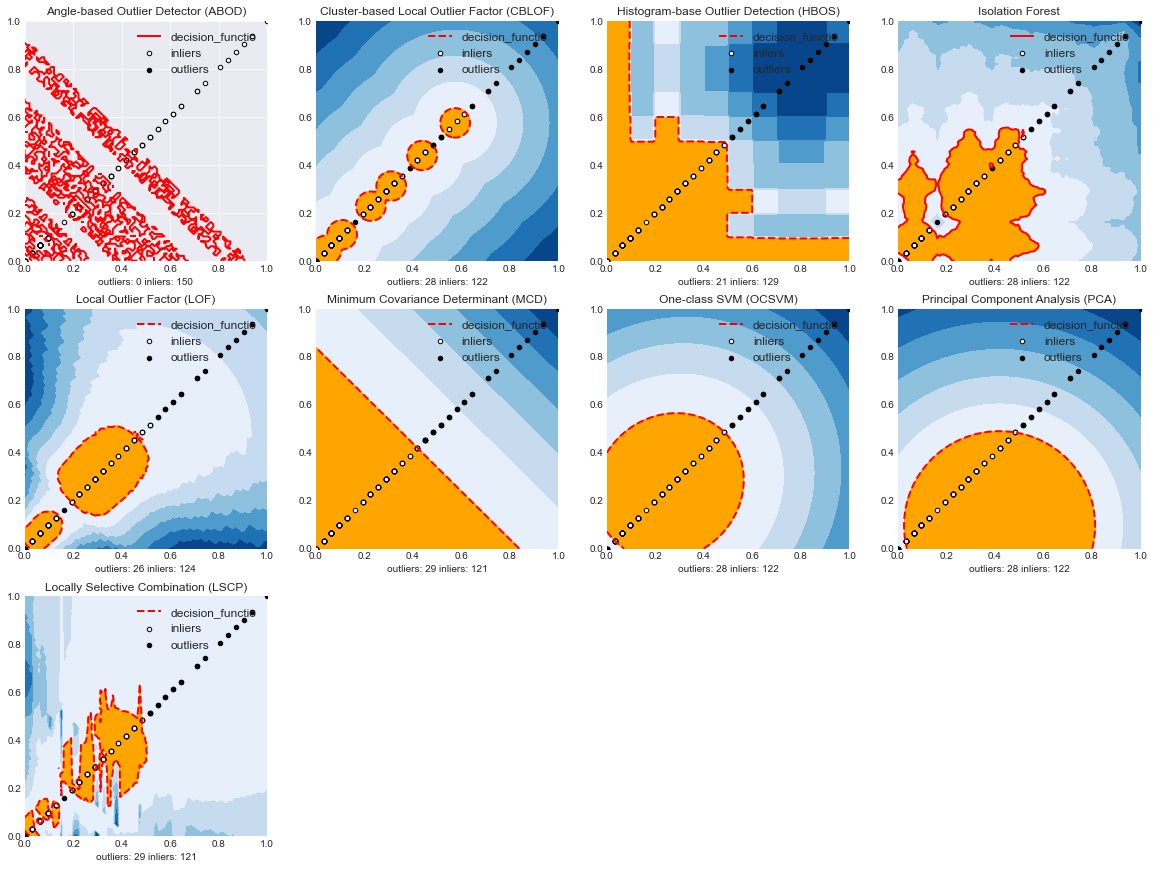

In [20]:
outliers_detection(data_a)

C:\Users\s0970\anaconda3\envs\tensorflow\lib\site-packages\numpy\core\fromnumeric.py:3583: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\s0970\anaconda3\envs\tensorflow\lib\site-packages\numpy\core\_methods.py:185: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
C:\Users\s0970\anaconda3\envs\tensorflow\lib\site-packages\numpy\core\_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\s0970\anaconda3\envs\tensorflow\lib\site-packages\pyod\models\base.py:429: RuntimeWarning: invalid value encountered in greater
  self.labels_ = (self.decision_scores_ > self.threshold_).astype(
C:\Users\s0970\anaconda3\envs\tensorflow\lib\site-packages\numpy\core\fromnumeric.py:3583: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\s0970\ana

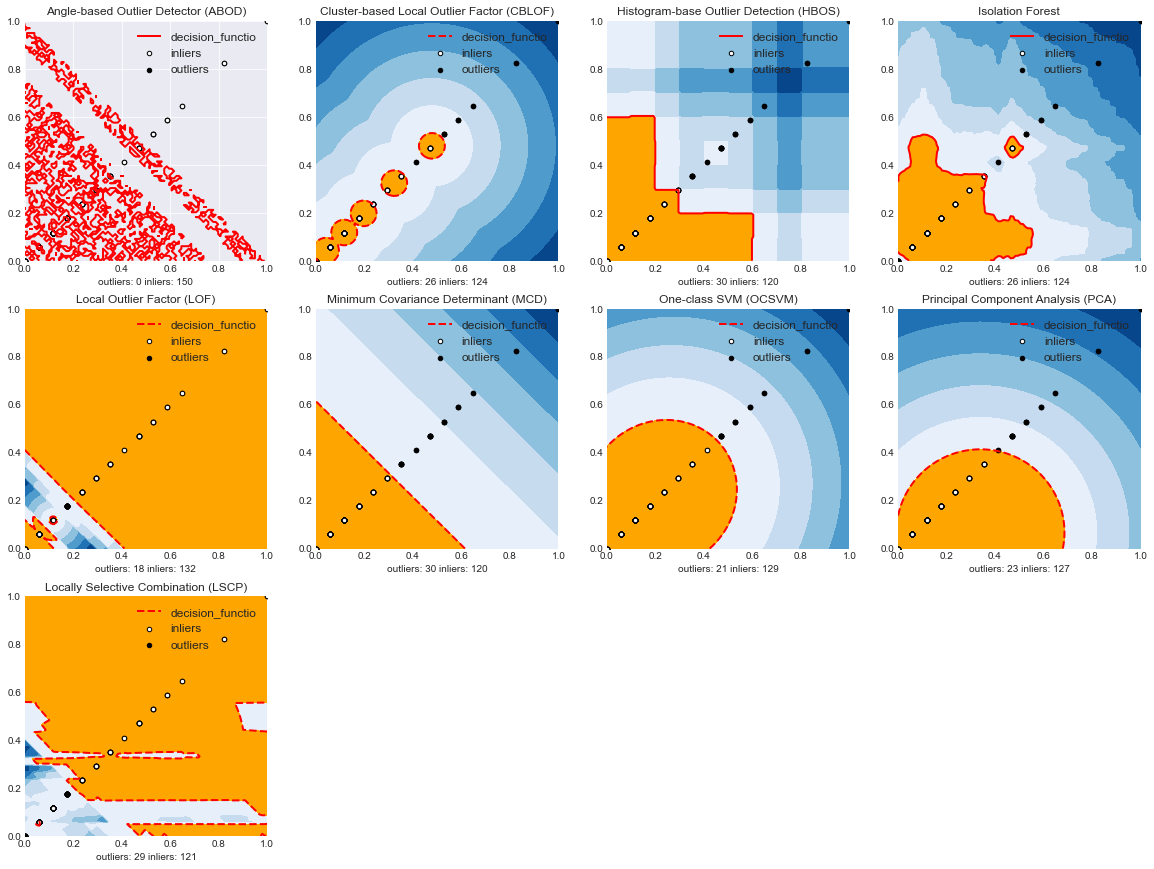

In [21]:
outliers_detection(data_b)

## 一維資料用box plot找出離群值

In [27]:
import seaborn as sns

In [25]:
tm_data = pd.concat([data_a,data_b],axis=1)

In [35]:
tm_data.columns=["(10.98~11.00)","(7.55~7.57)"]

Text(0.5, 1.0, 'box_plot to find outliers')

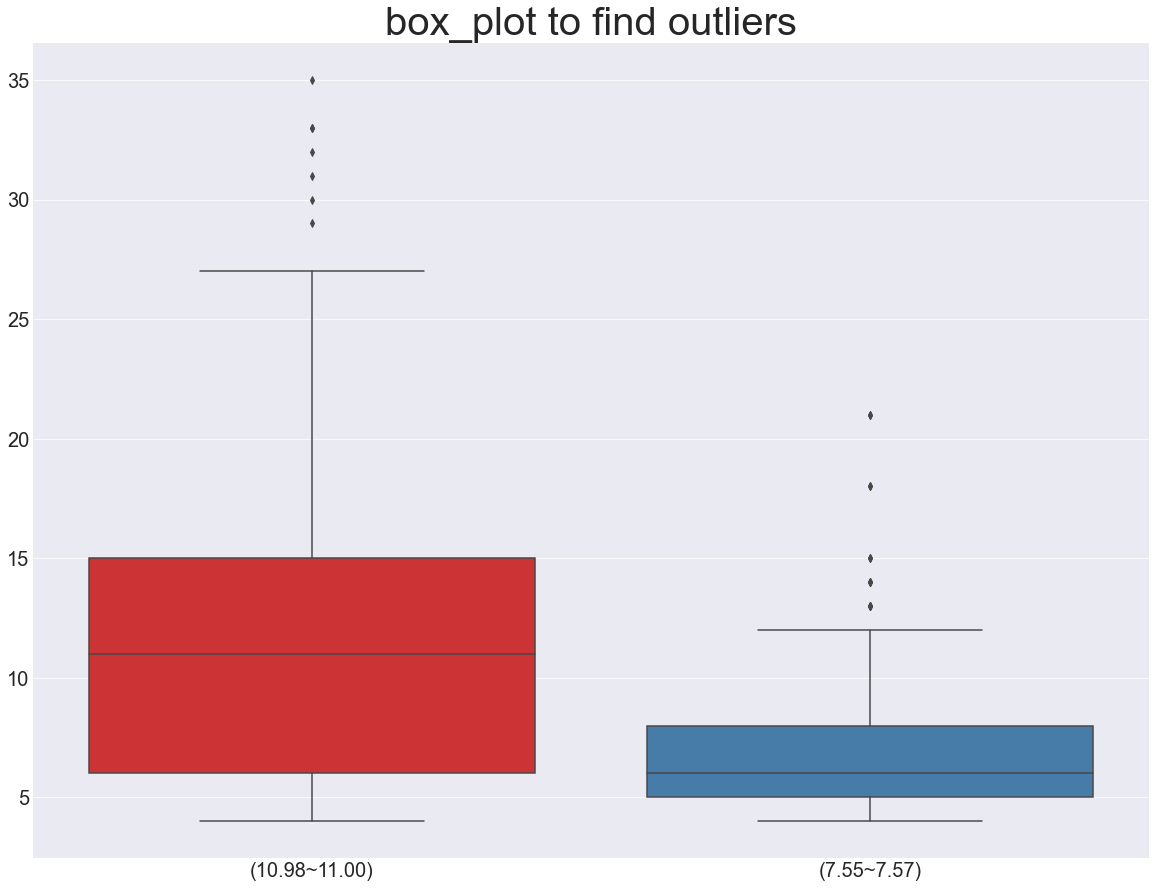

In [49]:
plt.figure(figsize=(20, 15))
sns.boxplot(data=tm_data,palette='Set1')
plt.xticks(size=20)
plt.yticks(size=20)
plt.title("box_plot to find outliers",size=40)